In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib import gridspec
from scipy import stats
from sklearn import preprocessing
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

# restart kernel
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True

Using TensorFlow backend.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/l

In [3]:
datafile="/data0/users/bpnachman/Gaia_data/gaiamock_ra156.2_dec57.5_stream_feh-1.6_v3_100.npy"
gaiadata=np.load(datafile)
gaiadata2=np.c_[gaiadata[:,0], gaiadata[:,1], gaiadata[:,2], gaiadata[:,3], gaiadata[:,4], gaiadata[:,5], gaiadata[:, 10]]
gaiadata2 = gaiadata2[np.sum(np.isnan(gaiadata2),axis=1)==0]
center_dec=0.5*(np.max(gaiadata2[:,2])+np.min(gaiadata2[:,2]))
center_ra=0.5*(np.max(gaiadata2[:,3])+np.min(gaiadata2[:,3]))
radius=np.sqrt((gaiadata2[:,2]-center_dec)**2+(gaiadata2[:,3]-center_ra)**2)
gaiadata2=gaiadata2[radius<15]
np.random.shuffle(gaiadata2)

In [4]:
stream_num = 100

In [5]:
gaiadata3 = np.c_[gaiadata[:,0], gaiadata[:,1], gaiadata[:,2], gaiadata[:,3], gaiadata[:,4], gaiadata[:,5], gaiadata[:,10]]
gaiadata3 = gaiadata3[np.where(gaiadata3[:,6] > 0)]
gaiadata3 = gaiadata3[np.sum(np.isnan(gaiadata3),axis=1)==0]
radius=np.sqrt((gaiadata3[:,2]-center_dec)**2+(gaiadata3[:,3]-center_ra)**2)
gaiadata3=gaiadata3[radius<15]
np.random.shuffle(gaiadata3)

In [6]:
gaiadata2_no_stream = np.c_[gaiadata[:,0], gaiadata[:,1], gaiadata[:,2], gaiadata[:,3], gaiadata[:,4], gaiadata[:,5], gaiadata[:,10]]
gaiadata2_no_stream = gaiadata2_no_stream[np.where(gaiadata2_no_stream[:,6] == 0)]
gaiadata2_no_stream = gaiadata2_no_stream[np.sum(np.isnan(gaiadata2_no_stream),axis=1)==0]
radius=np.sqrt((gaiadata2_no_stream[:,2]-center_dec)**2+(gaiadata2_no_stream[:,3]-center_ra)**2)
gaiadata2_no_stream=gaiadata2_no_stream[radius<15]
np.random.shuffle(gaiadata2_no_stream)                            

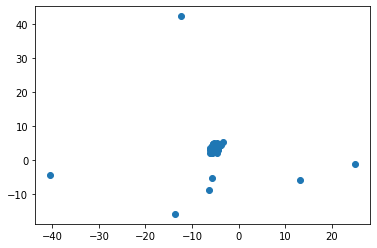

In [7]:
plt.scatter(gaiadata3[:,1],gaiadata3[:,0])

Text(0, 0.5, '$\\mu_\\delta$ [$\\mu$as/year]')

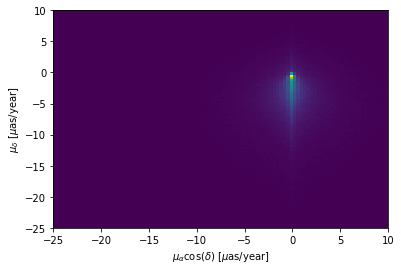

In [8]:
_,_,_,_=plt.hist2d(gaiadata2[:,1]*np.cos(gaiadata2[:,2]),gaiadata2[:,0],bins=[np.linspace(-25,10,100),np.linspace(-25,10,100)])
plt.xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]")
plt.ylabel(r"$\mu_\delta$ [$\mu$as/year]")

Text(0, 0.5, '$\\delta$ [degrees]')

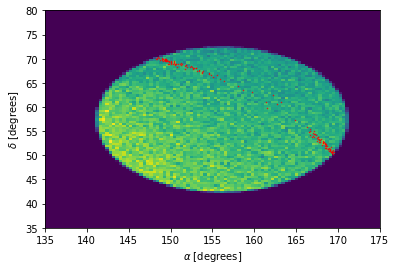

In [9]:
_,_,_,_=plt.hist2d(gaiadata2[:,3],gaiadata2[:,2], bins=[np.linspace(135,175,100),np.linspace(35,80,100)])
plt.scatter(gaiadata3[:,3],gaiadata3[:,2],color='red',s=0.2)
plt.xlabel(r"$\alpha$ [degrees]")
plt.ylabel(r"$\delta$ [degrees]")

Text(0.5, 0, '$\\mu_\\delta$ [$\\mu$as/year]')

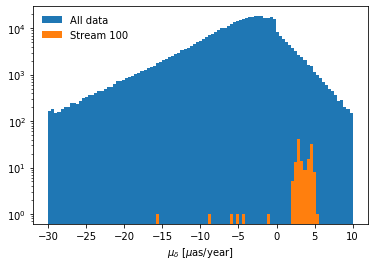

In [10]:
_,_,_=plt.hist(gaiadata2[:,0],bins=np.linspace(-30,10,100),label="All data")
_,_,_=plt.hist(gaiadata3[:,0],bins=np.linspace(-30,10,100),label="Stream " + str(stream_num))
plt.legend(frameon=False)
plt.yscale("log")
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")

In [11]:
def build_signal_sideband_stream(data, stream):
    return data[(data[:,0] > 2)*(data[:,0] < 5)], data[(data[:,0] > 0.8)*(data[:,0] < 2)+(data[:,0] > 5)*(data[:,0] < 6.2)], stream


In [12]:
def build_data_arrays(SR, SB, stream, theta):
    X = SR[:,3]-center_ra
    Y = SR[:,2]-center_dec

    Xr = X*np.cos(theta) + Y*np.sin(theta)
    Yr = -X*np.sin(theta) + Y*np.cos(theta)

    Xb = SB[:,3]-center_ra
    Yb = SB[:,2]-center_dec

    Xbr = Xb*np.cos(theta) + Yb*np.sin(theta)
    Ybr = -Xb*np.sin(theta) + Yb*np.cos(theta)

    Xs = stream[:,3]-center_ra
    Ys = stream[:,2]-center_dec

    Xsr = Xs*np.cos(theta) + Ys*np.sin(theta)
    Ysr = -Xs*np.sin(theta) + Ys*np.cos(theta)

    SR = np.c_[SR[:,0],SR[:,1],Xr, Yr, SR[:,4],SR[:,5], SR[:,6]]
    SB = np.c_[SB[:,0],SB[:,1],Xbr, Ybr, SB[:,4],SB[:,5], SB[:,6]]
    stream = np.c_[stream[:,0],stream[:,1],Xsr, Ysr, stream[:,4],stream[:,5], stream[:,6]]
    
    return SR, SB, stream

In [13]:
def build_model(SR, SB, stream):
    X = np.concatenate([SR,SB,stream])
    Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB)),2.*np.ones(len(stream))])
    X_scaled = preprocessing.scale(X[:, :6])
    X_scaled = np.c_[X_scaled, X[:, 6]]
    stream_scaled = X_scaled[Y==2]
    X_scaled = X_scaled[Y<2]
    Y = Y[Y<2]
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5)

    tpr_arr = []
    fpr_arr = []
    stream_background_x_arr = []
    stream_background_y_arr = []

    for i in range(20):

        model = Sequential()
        model.add(Dense(64, input_dim=5, activation='relu')) 
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(X_train[:,1:6],Y_train, epochs=20, batch_size=200,validation_data=(X_test[:,1:6],Y_test), verbose = 0) 

        preds = model.predict(X_test[:,1:6], batch_size=int(0.1*len(X_test)))
        preds_SR = preds[(Y_test == 1) * (X_test[:, 6] == 0)]

        preds_stream = model.predict(stream_scaled[:,1:6], batch_size=int(0.1*len(stream_scaled)))

        fpr, tpr, thresholds = roc_curve(np.concatenate([np.zeros(len(preds_SR)),np.ones(len(preds_stream))]), np.concatenate([preds_SR,preds_stream]))
        fpr2, tpr2, thresholds2 = roc_curve(Y_test, preds)
        
        tpr_arr.append(tpr)
        fpr_arr.append(fpr)
        stream_background_x_arr.append(tpr2)
        stream_background_y_arr.append(fpr2)
    
    return tpr_arr, fpr_arr, stream_background_x_arr, stream_background_y_arr

# Test on data that is not rotated 

In [52]:
SR, SB, stream = build_signal_sideband_stream(gaiadata2, gaiadata3) 

SR, SB, stream = build_data_arrays(SR, SB, stream, 0)

In [56]:
original_sig = (sum(SR[:,6] != 0))/np.sqrt(sum(SR[:,6] == 0))

## Histograms for non-rotated data

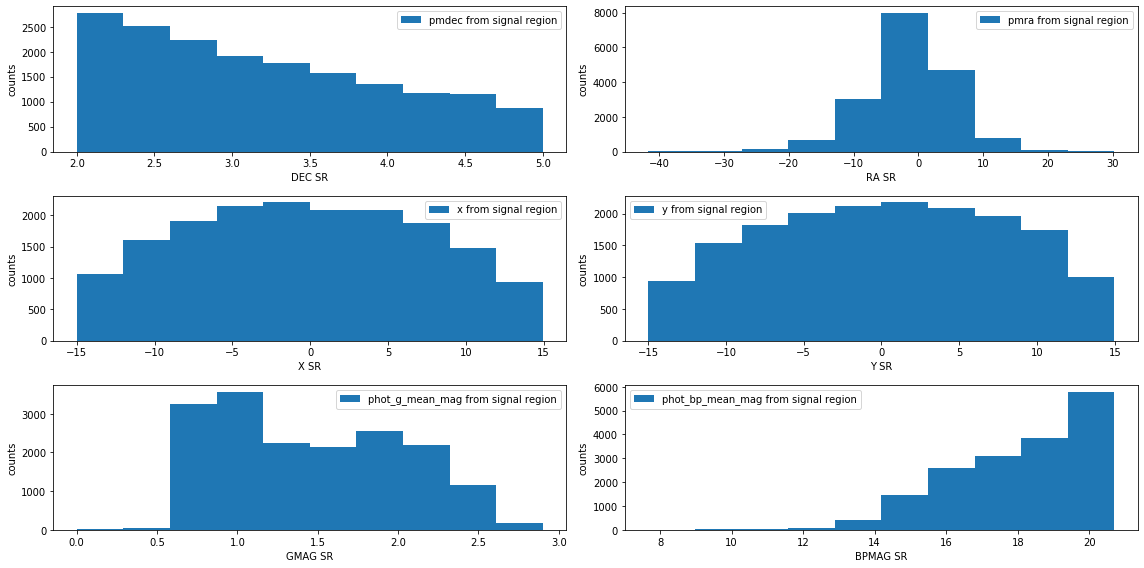

In [15]:
#SIGNAL REGION HISTOGRAMS
plt.figure(figsize = (16, 8))
plt.subplot(321)
plt.hist(SR[:, 0], label = "pmdec from signal region") 
plt.xlabel("DEC SR")
plt.ylabel("counts")
plt.legend()

plt.subplot(322)
plt.hist(SR[:, 1], label = "pmra from signal region") 
plt.xlabel("RA SR")
plt.ylabel("counts")
plt.legend()

plt.subplot(323)
plt.hist(SR[:, 2], label = "x from signal region")
plt.xlabel("X SR")
plt.ylabel("counts")
plt.legend()

plt.subplot(324)
plt.hist(SR[:, 3], label = 'y from signal region')
plt.xlabel("Y SR")
plt.ylabel("counts")
plt.legend()

plt.subplot(325)
plt.hist(SR[:, 4], label = 'phot_g_mean_mag from signal region')
plt.xlabel("GMAG SR")
plt.ylabel("counts")
plt.legend()

plt.subplot(326)
plt.hist(SR[:, 5], label = 'phot_bp_mean_mag from signal region')
plt.xlabel("BPMAG SR")
plt.ylabel("counts")
plt.legend()

plt.tight_layout()

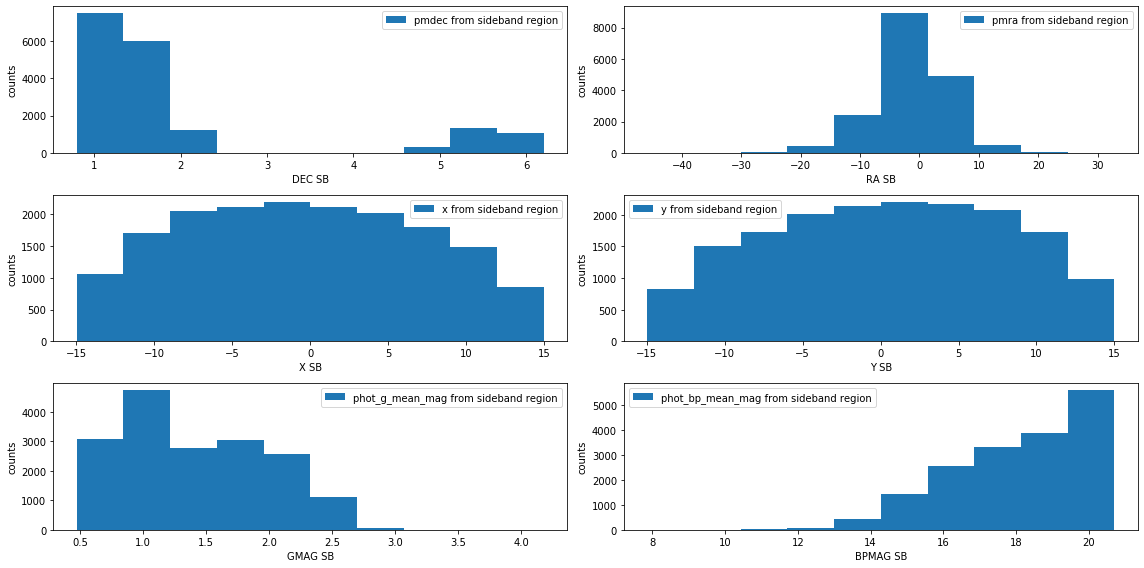

In [16]:
#SIDEBAND REGION HISTOGRAMS
plt.figure(figsize = (16, 8))
plt.subplot(321)
plt.hist(SB[:, 0], label = "pmdec from sideband region")
plt.xlabel("DEC SB")
plt.ylabel("counts")
plt.legend()

plt.subplot(322)
plt.hist(SB[:, 1], label = "pmra from sideband region")
plt.xlabel("RA SB")
plt.ylabel("counts")
plt.legend()

plt.subplot(323)
plt.hist(SB[:, 2], label = "x from sideband region")
plt.xlabel("X SB")
plt.ylabel("counts")
plt.legend()

plt.subplot(324)
plt.hist(SB[:, 3], label = 'y from sideband region')
plt.xlabel("Y SB")
plt.ylabel("counts")
plt.legend()

plt.subplot(325)
plt.hist(SB[:, 4], label = 'phot_g_mean_mag from sideband region')
plt.xlabel("GMAG SB")
plt.ylabel("counts")
plt.legend()

plt.subplot(326)
plt.hist(SB[:, 5], label = 'phot_bp_mean_mag from sideband region')
plt.xlabel("BPMAG SB")
plt.ylabel("counts")
plt.legend()

plt.tight_layout()

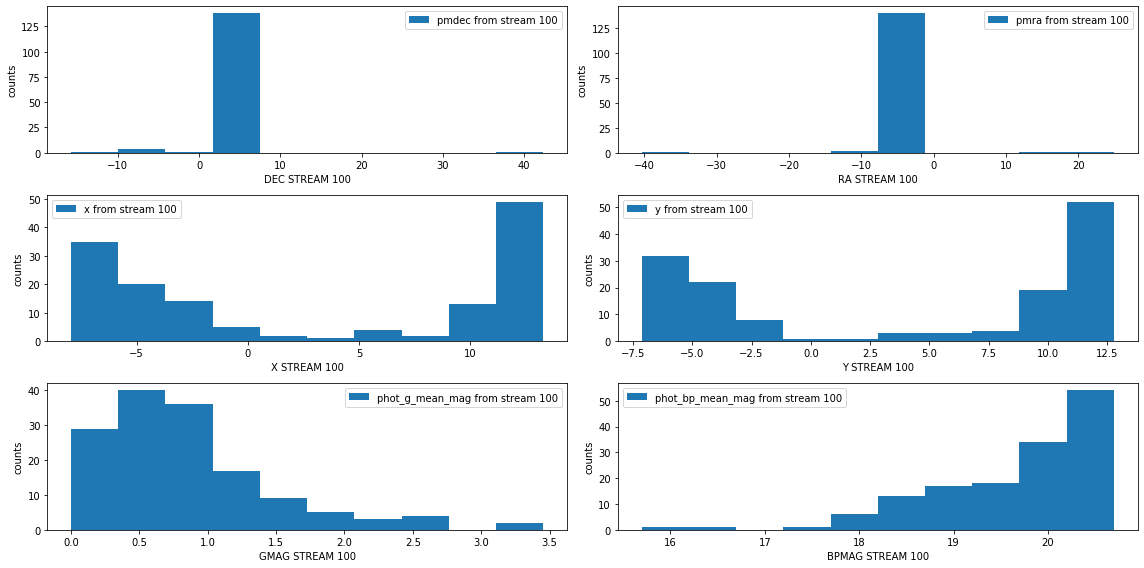

In [17]:
#STREAM HISTOGRAMS 
plt.figure(figsize = (16, 8))
plt.subplot(321)
plt.hist(stream[:, 0], label = "pmdec from stream " + str(stream_num))
plt.xlabel("DEC STREAM " + str(stream_num))
plt.ylabel("counts")
plt.legend()

plt.subplot(322)
plt.hist(stream[:, 1], label = "pmra from stream " + str(stream_num))
plt.xlabel("RA STREAM " + str(stream_num))
plt.ylabel("counts")
plt.legend()

plt.subplot(323)
plt.hist(stream[:, 2], label = "x from stream " + str(stream_num))
plt.xlabel("X STREAM " + str(stream_num))
plt.ylabel("counts")
plt.legend()

plt.subplot(324)
plt.hist(stream[:, 3], label = "y from stream " + str(stream_num))
plt.xlabel("Y STREAM " + str(stream_num))
plt.ylabel("counts")
plt.legend()

plt.subplot(325)
plt.hist(stream[:, 4], label = "phot_g_mean_mag from stream " + str(stream_num))
plt.xlabel("GMAG STREAM " + str(stream_num))
plt.ylabel("counts")
plt.legend()

plt.subplot(326)
plt.hist(stream[:, 5], label = "phot_bp_mean_mag from stream " + str(stream_num))
plt.xlabel("BPMAG STREAM " + str(stream_num))
plt.ylabel("counts")
plt.legend()

plt.tight_layout()

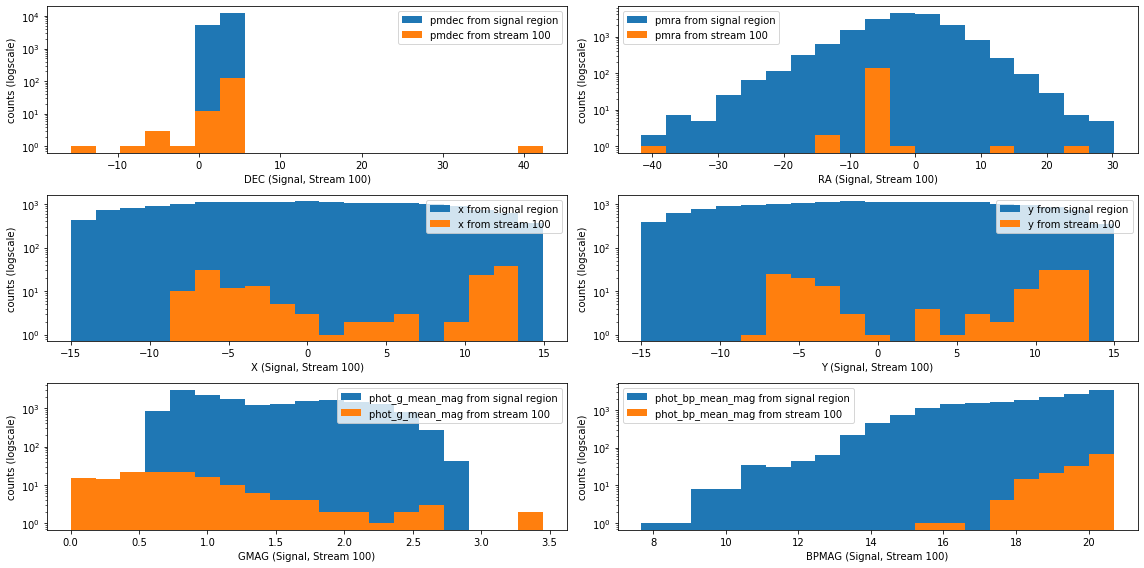

In [18]:
#OVERLAY SIGNAL AND STREAM HISTOGRAMS
plt.figure(figsize = (16, 8))
plt.subplot(321)
min_b = min(min(SR[:, 0]), min(stream[:, 0]))
max_b = max(max(SR[:, 0]), max(stream[:, 0]))
plt.hist(SR[:, 0], bins = np.linspace(min_b, max_b, 20), label = "pmdec from signal region") 
plt.hist(stream[:, 0], bins = np.linspace(min_b, max_b, 20), label = "pmdec from stream " + str(stream_num))
plt.xlabel("DEC (Signal, Stream " + str(stream_num) + ")")
plt.ylabel("counts (logscale)")
plt.yscale('log')
plt.legend()

plt.subplot(322)
min_b = min(min(SR[:, 1]), min(stream[:, 1]))
max_b = max(max(SR[:, 1]), max(stream[:, 1]))
plt.hist(SR[:, 1], bins = np.linspace(min_b, max_b, 20), label = "pmra from signal region") 
plt.hist(stream[:, 1], bins = np.linspace(min_b, max_b, 20), label = "pmra from stream " + str(stream_num))
plt.xlabel("RA (Signal, Stream " + str(stream_num) + ")")
plt.ylabel("counts (logscale)")
plt.yscale('log')
plt.legend()

plt.subplot(323)
min_b = min(min(SR[:, 2]), min(stream[:, 2]))
max_b = max(max(SR[:, 2]), max(stream[:, 2]))
plt.hist(SR[:, 2], bins = np.linspace(min_b, max_b, 20), label = "x from signal region")
plt.hist(stream[:, 2], bins = np.linspace(min_b, max_b, 20), label = "x from stream " + str(stream_num))
plt.xlabel("X (Signal, Stream " + str(stream_num) + ")")
plt.ylabel("counts (logscale)")
plt.yscale('log')
plt.legend()

plt.subplot(324)
min_b = min(min(SR[:, 3]), min(stream[:, 3]))
max_b = max(max(SR[:, 3]), max(stream[:, 3]))
plt.hist(SR[:, 3], bins = np.linspace(min_b, max_b, 20), label = 'y from signal region')
plt.hist(stream[:, 3], bins = np.linspace(min_b, max_b, 20), label = "y from stream " + str(stream_num))
plt.xlabel("Y (Signal, Stream " + str(stream_num) + ")")
plt.ylabel("counts (logscale)")
plt.yscale('log')
plt.legend()

plt.subplot(325)
min_b = min(min(SR[:, 4]), min(stream[:, 4]))
max_b = max(max(SR[:, 4]), max(stream[:, 4]))
plt.hist(SR[:, 4], bins = np.linspace(min_b, max_b, 20), label = 'phot_g_mean_mag from signal region')
plt.hist(stream[:, 4], bins = np.linspace(min_b, max_b, 20), label = "phot_g_mean_mag from stream " + str(stream_num))
plt.xlabel("GMAG (Signal, Stream " + str(stream_num) + ")")
plt.ylabel("counts (logscale)")
plt.yscale('log')
plt.legend()

plt.subplot(326)
min_b = min(min(SR[:, 5]), min(stream[:, 5]))
max_b = max(max(SR[:, 5]), max(stream[:, 5]))
plt.hist(SR[:,5], bins = np.linspace(min_b, max_b, 20), label = 'phot_bp_mean_mag from signal region')
plt.hist(stream[:,5], bins = np.linspace(min_b, max_b, 20), label = "phot_bp_mean_mag from stream " + str(stream_num))
plt.xlabel("BPMAG (Signal, Stream " + str(stream_num) + ")")
plt.ylabel("counts (logscale)")
plt.yscale('log')
plt.legend()

plt.tight_layout()

Text(0, 0.5, 'RA Stream 100')

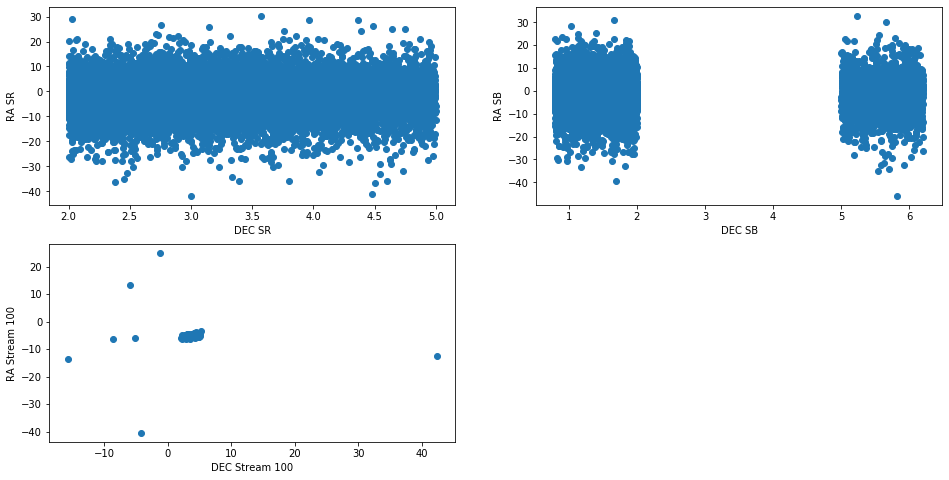

In [19]:
#PLOT DEC VS RA
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 0], SR[:, 1])
plt.xlabel("DEC SR")
plt.ylabel("RA SR")

plt.subplot(222)
plt.scatter(SB[:, 0], SB[:, 1])
plt.xlabel("DEC SB")
plt.ylabel("RA SB")

plt.subplot(223)
plt.scatter(stream[: ,0], stream[:, 1])
plt.xlabel("DEC Stream " + str(stream_num))
plt.ylabel("RA Stream " + str(stream_num))

Text(0, 0.5, 'X Stream 100')

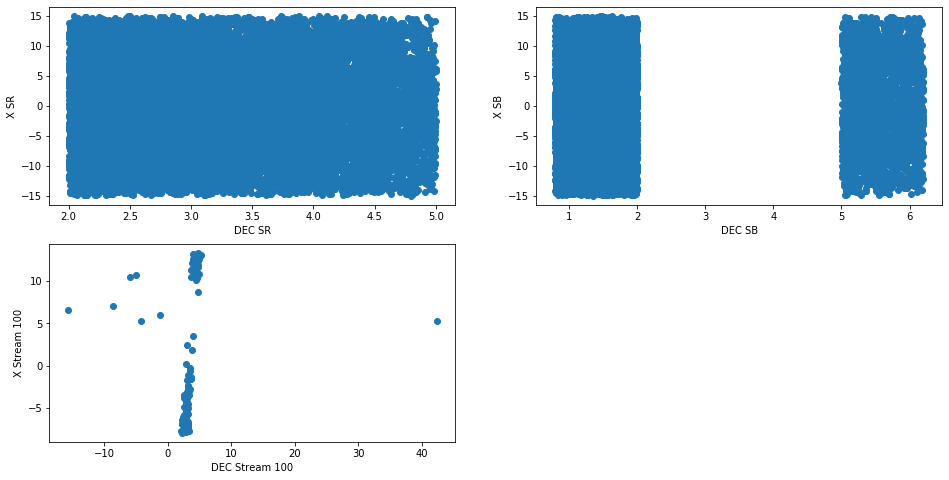

In [20]:
#PLOT DEC VS X
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 0], SR[:, 2])
plt.xlabel("DEC SR")
plt.ylabel("X SR")

plt.subplot(222)
plt.scatter(SB[:, 0], SB[:, 2])
plt.xlabel("DEC SB")
plt.ylabel("X SB")

plt.subplot(223)
plt.scatter(stream[: ,0], stream[:, 2])
plt.xlabel("DEC Stream " + str(stream_num))
plt.ylabel("X Stream " + str(stream_num))

Text(0, 0.5, 'Y Stream 100')

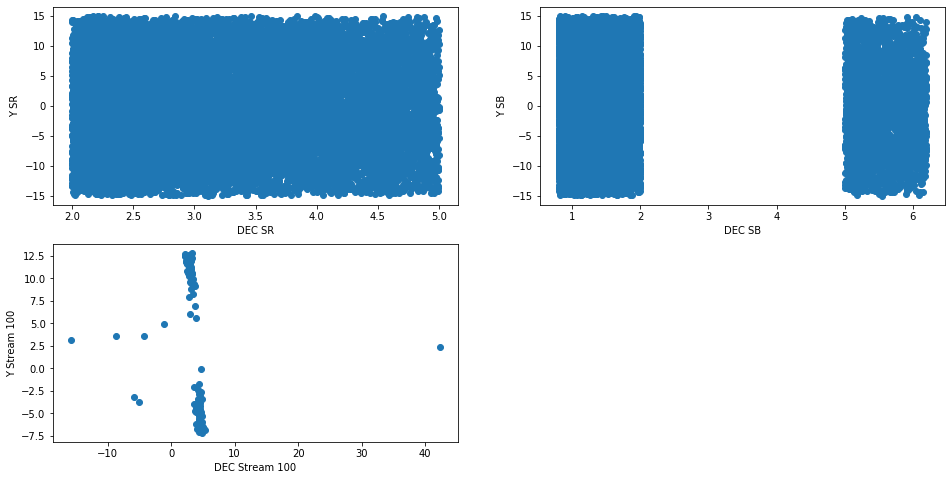

In [21]:
#PLOT DEC VS Y
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 0], SR[:, 3])
plt.xlabel("DEC SR")
plt.ylabel("Y SR")

plt.subplot(222)
plt.scatter(SB[:, 0], SB[:, 3])
plt.xlabel("DEC SB")
plt.ylabel("Y SB")

plt.subplot(223)
plt.scatter(stream[: ,0], stream[:, 3])
plt.xlabel("DEC Stream " + str(stream_num))
plt.ylabel("Y Stream " + str(stream_num))

Text(0, 0.5, 'GMAG Stream 100')

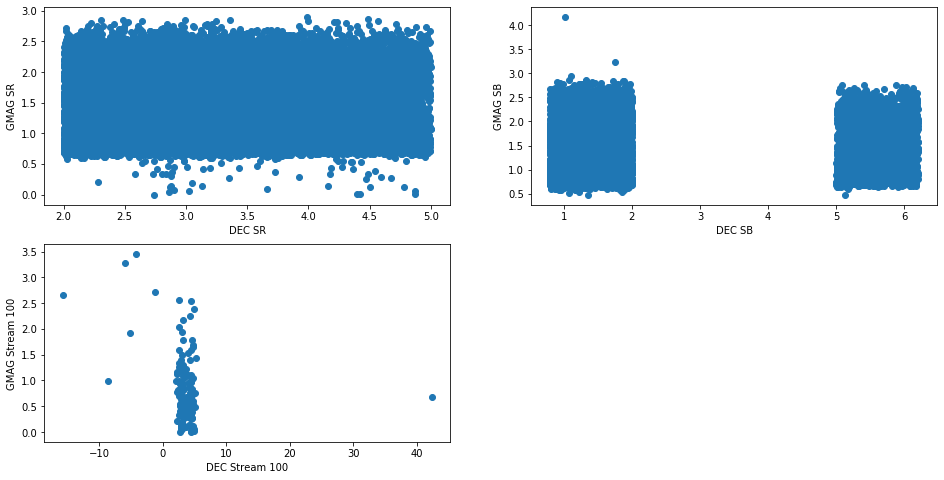

In [22]:
#PLOT DEC VS GMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 0], SR[:, 4])
plt.xlabel("DEC SR")
plt.ylabel("GMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 0], SB[:, 4])
plt.xlabel("DEC SB")
plt.ylabel("GMAG SB")

plt.subplot(223)
plt.scatter(stream[: ,0], stream[:, 4])
plt.xlabel("DEC Stream " + str(stream_num))
plt.ylabel("GMAG Stream " + str(stream_num))

Text(0, 0.5, 'BPMAG Stream 100')

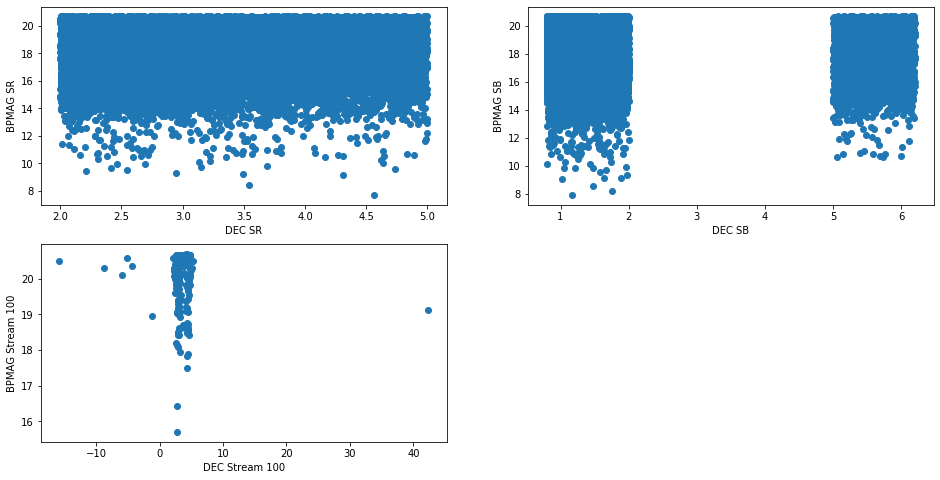

In [23]:
#PLOT DEC VS BPMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 0], SR[:, 5])
plt.xlabel("DEC SR")
plt.ylabel("BPMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 0], SB[:, 5])
plt.xlabel("DEC SB")
plt.ylabel("BPMAG SB")

plt.subplot(223)
plt.scatter(stream[: ,0], stream[:, 5])
plt.xlabel("DEC Stream " + str(stream_num))
plt.ylabel("BPMAG Stream " + str(stream_num))

Text(0, 0.5, 'X Stream 100')

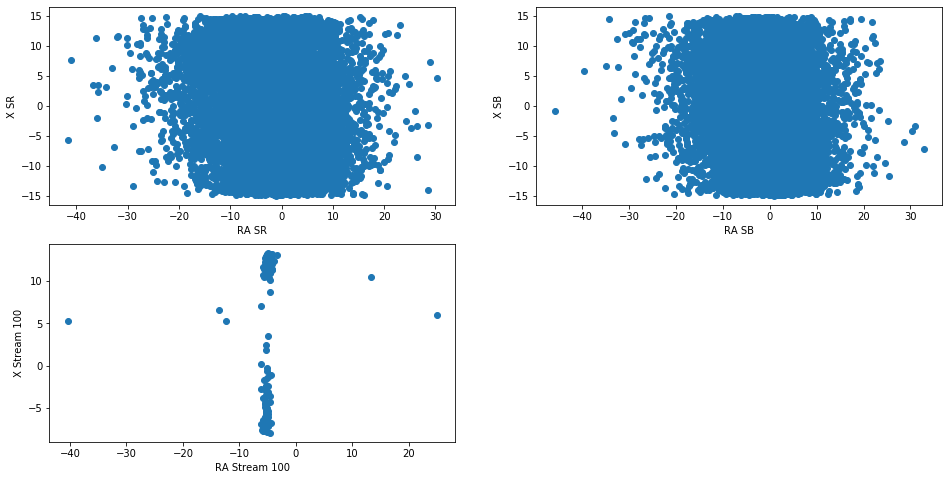

In [24]:
#PLOT RA VS X
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 1], SR[:, 2])
plt.xlabel("RA SR")
plt.ylabel("X SR")

plt.subplot(222)
plt.scatter(SB[:, 1], SB[:, 2])
plt.xlabel("RA SB")
plt.ylabel("X SB")

plt.subplot(223)
plt.scatter(stream[: ,1], stream[:, 2])
plt.xlabel("RA Stream " + str(stream_num))
plt.ylabel("X Stream " + str(stream_num))

Text(0, 0.5, 'Y Stream 100')

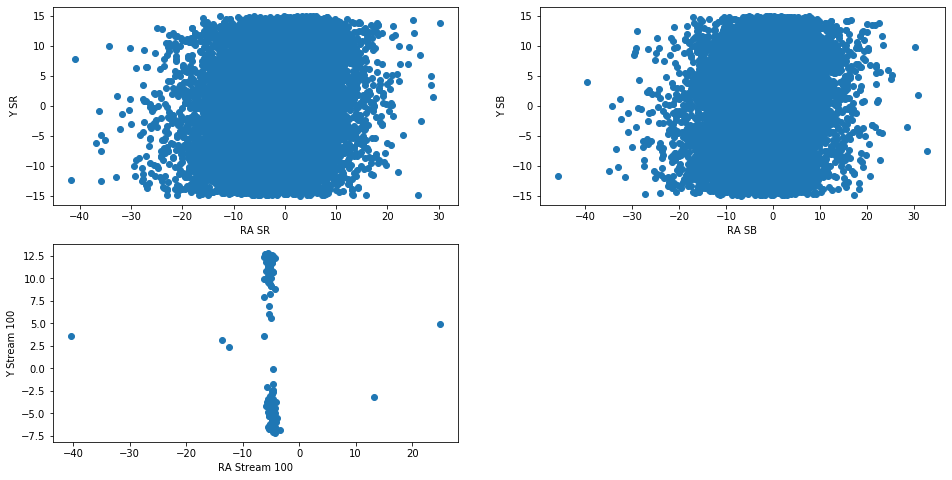

In [25]:
#PLOT RA VS Y
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 1], SR[:, 3])
plt.xlabel("RA SR")
plt.ylabel("Y SR")

plt.subplot(222)
plt.scatter(SB[:, 1], SB[:, 3])
plt.xlabel("RA SB")
plt.ylabel("Y SB")

plt.subplot(223)
plt.scatter(stream[: ,1], stream[:, 3])
plt.xlabel("RA Stream " + str(stream_num))
plt.ylabel("Y Stream " + str(stream_num))

Text(0, 0.5, 'GMAG Stream 100')

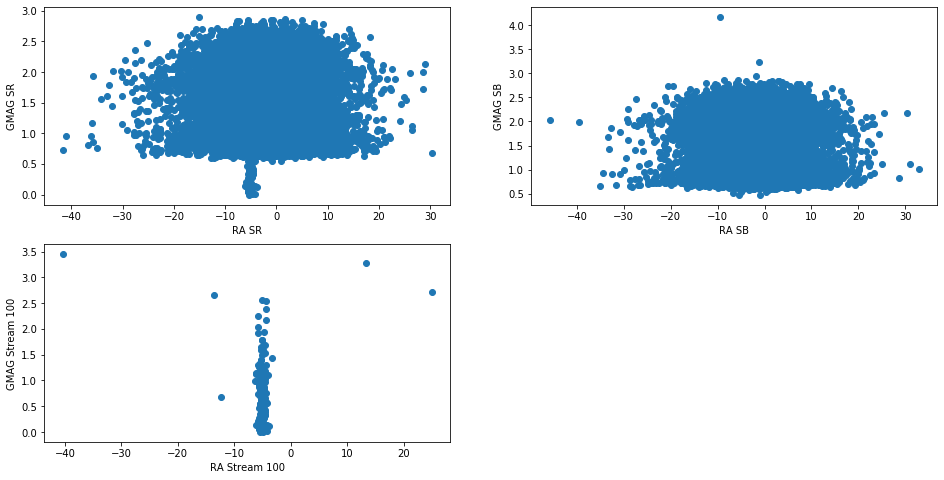

In [26]:
#PLOT RA VS GMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 1], SR[:, 4])
plt.xlabel("RA SR")
plt.ylabel("GMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 1], SB[:, 4])
plt.xlabel("RA SB")
plt.ylabel("GMAG SB")

plt.subplot(223)
plt.scatter(stream[: ,1], stream[:, 4])
plt.xlabel("RA Stream " + str(stream_num))
plt.ylabel("GMAG Stream " + str(stream_num))

Text(0, 0.5, 'BPMAG Stream 100')

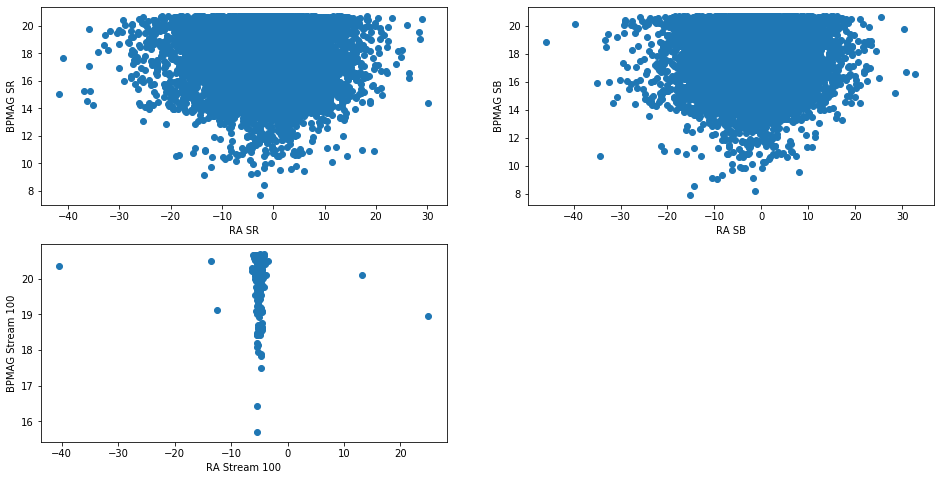

In [27]:
#PLOT RA VS GMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 1], SR[:, 5])
plt.xlabel("RA SR")
plt.ylabel("BPMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 1], SB[:, 5])
plt.xlabel("RA SB")
plt.ylabel("BPMAG SB")

plt.subplot(223)
plt.scatter(stream[: ,1], stream[:, 5])
plt.xlabel("RA Stream " + str(stream_num))
plt.ylabel("BPMAG Stream " + str(stream_num))

Text(0, 0.5, 'Y Stream 100')

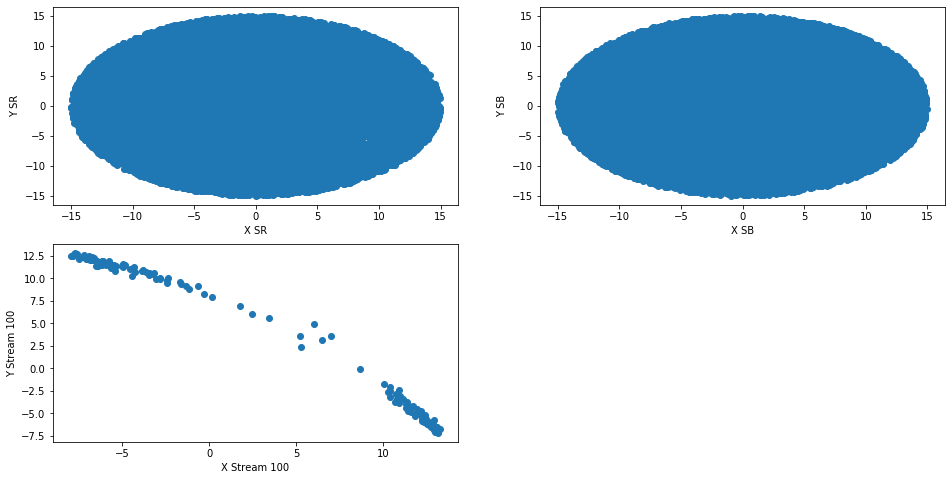

In [28]:
#PLOT X VS Y
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 2], SR[:, 3])
plt.xlabel("X SR")
plt.ylabel("Y SR")

plt.subplot(222)
plt.scatter(SB[:, 2], SB[:, 3])
plt.xlabel("X SB")
plt.ylabel("Y SB")

plt.subplot(223)
plt.scatter(stream[:, 2], stream[:, 3])
plt.xlabel("X Stream " + str(stream_num))
plt.ylabel("Y Stream " + str(stream_num))

Text(0, 0.5, 'GMAG Stream 100')

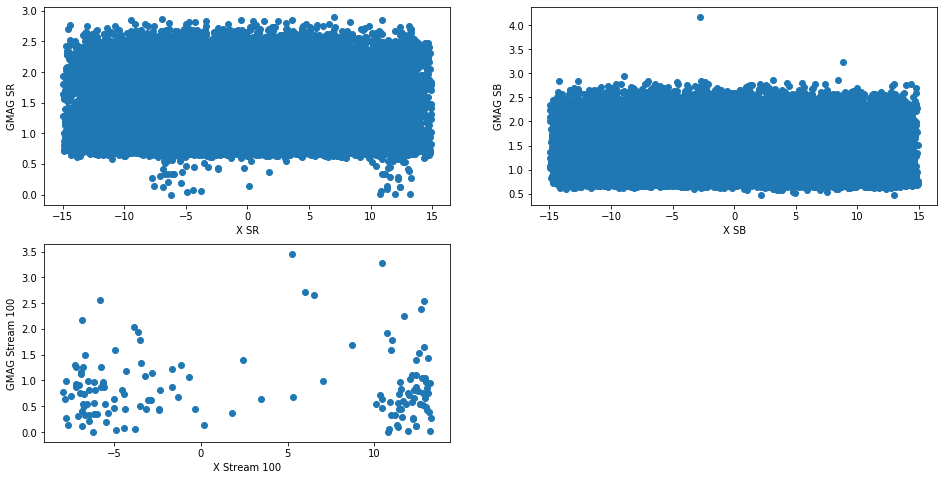

In [29]:
#PLOT X VS GMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 2], SR[:, 4])
plt.xlabel("X SR")
plt.ylabel("GMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 2], SB[:, 4])
plt.xlabel("X SB")
plt.ylabel("GMAG SB")

plt.subplot(223)
plt.scatter(stream[:, 2], stream[:, 4])
plt.xlabel("X Stream " + str(stream_num))
plt.ylabel("GMAG Stream " + str(stream_num))

Text(0, 0.5, 'BPMAG Stream 100')

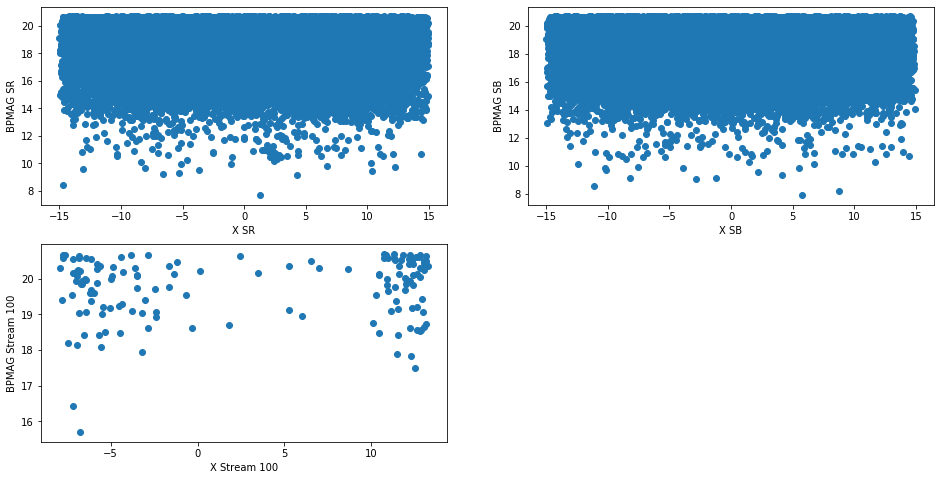

In [30]:
#PLOT X VS BPMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 2], SR[:, 5])
plt.xlabel("X SR")
plt.ylabel("BPMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 2], SB[:, 5])
plt.xlabel("X SB")
plt.ylabel("BPMAG SB")

plt.subplot(223)
plt.scatter(stream[:, 2], stream[:, 5])
plt.xlabel("X Stream " + str(stream_num))
plt.ylabel("BPMAG Stream " + str(stream_num))

Text(0, 0.5, 'GMAG Stream 100')

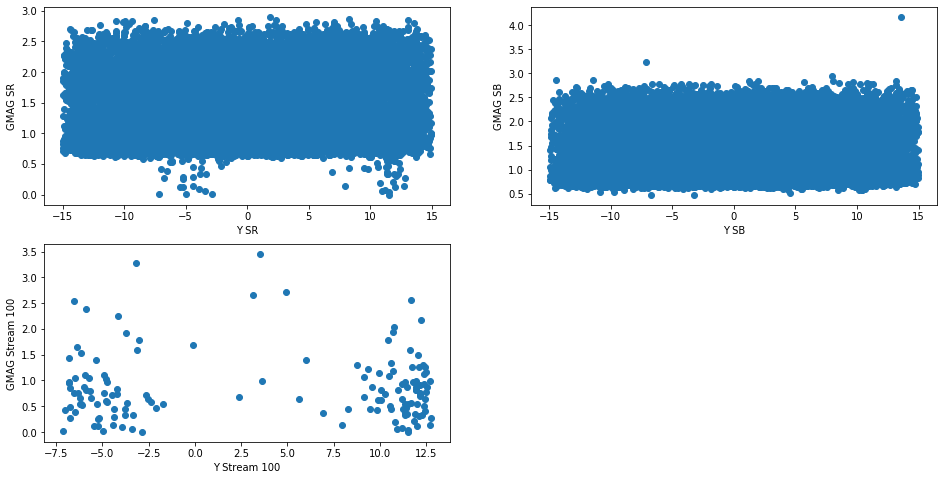

In [31]:
#PLOT Y VS GMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 3], SR[:, 4])
plt.xlabel("Y SR")
plt.ylabel("GMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 3], SB[:, 4])
plt.xlabel("Y SB")
plt.ylabel("GMAG SB")

plt.subplot(223)
plt.scatter(stream[:, 3], stream[:, 4])
plt.xlabel("Y Stream " + str(stream_num))
plt.ylabel("GMAG Stream " + str(stream_num))

Text(0, 0.5, 'BPMAG Stream 100')

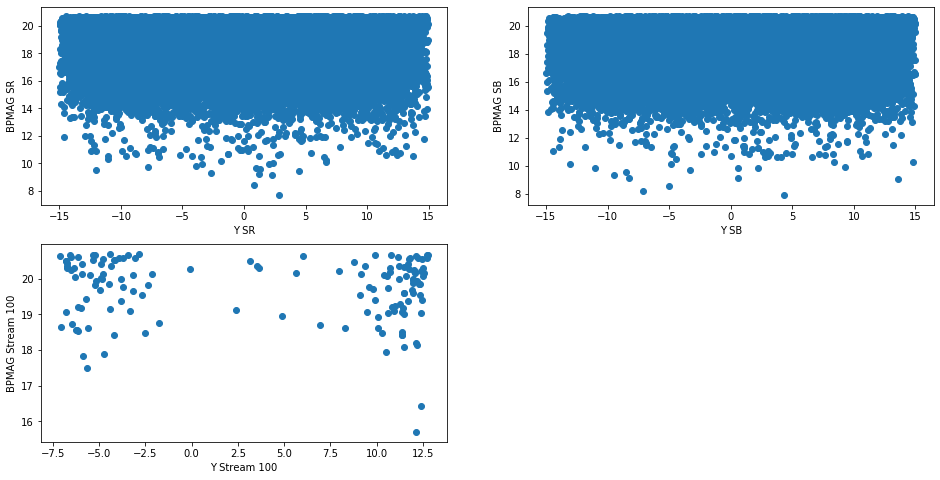

In [32]:
#PLOT Y VS BPMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 3], SR[:, 5])
plt.xlabel("Y SR")
plt.ylabel("BPMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 3], SB[:, 5])
plt.xlabel("Y SB")
plt.ylabel("BPMAG SB")

plt.subplot(223)
plt.scatter(stream[:, 3], stream[:, 5])
plt.xlabel("Y Stream " + str(stream_num))
plt.ylabel("BPMAG Stream " + str(stream_num))

Text(0, 0.5, 'BPMAG Stream 100')

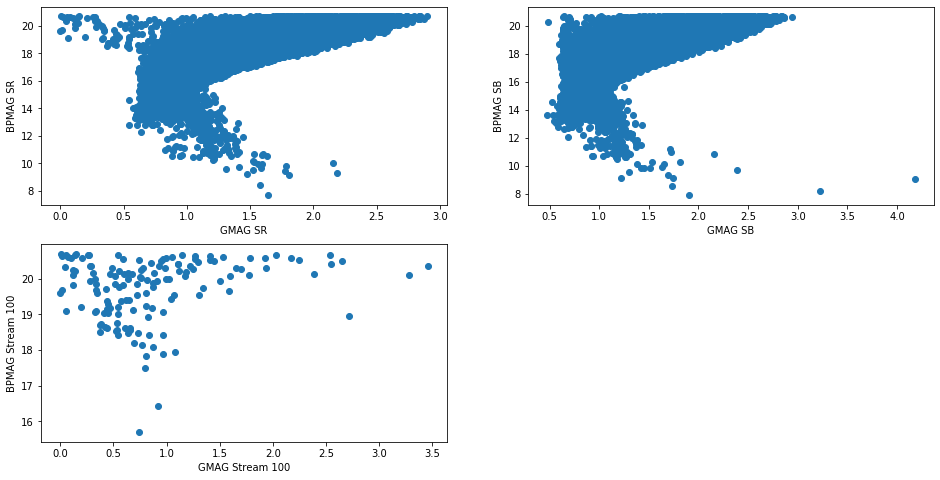

In [33]:
#PLOT GMAG VS BPMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 4], SR[:, 5])
plt.xlabel("GMAG SR")
plt.ylabel("BPMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 4], SB[:, 5])
plt.xlabel("GMAG SB")
plt.ylabel("BPMAG SB")

plt.subplot(223)
plt.scatter(stream[:, 4], stream[:, 5])
plt.xlabel("GMAG Stream " + str(stream_num))
plt.ylabel("BPMAG Stream " + str(stream_num))

Text(0, 0.5, 'counts')

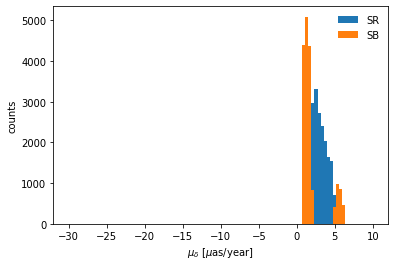

In [34]:
_,_,_=plt.hist(SR[:,0],bins=np.linspace(-30,10,100),label="SR")
_,_,_=plt.hist(SB[:,0],bins=np.linspace(-30,10,100),label="SB")
plt.legend(frameon=False)
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")
plt.ylabel("counts")

In [35]:
tpr_no_rot, fpr_no_rot, tpr_no_rot_stream_background, fpr_no_rot_stream_background = build_model(SR, SB, stream)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


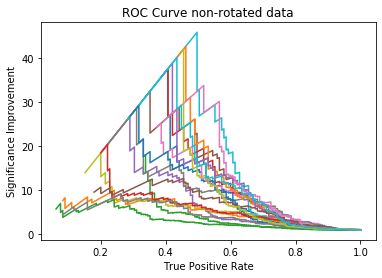

In [36]:
for x, y in zip(tpr_no_rot, fpr_no_rot):
    plt.plot(x, x/y**0.5)
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.title("ROC Curve non-rotated data")
plt.show()

# Remove Stream

In [37]:
SR, SB, stream = build_signal_sideband_stream(gaiadata2_no_stream, gaiadata3)

SR, SB, stream = build_data_arrays(SR, SB, stream, 0)


In [38]:
tpr_no_stream, fpr_no_stream, tpr_no_stream_stream_background, fpr_no_stream_stream_background = build_model(SR, SB, stream)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


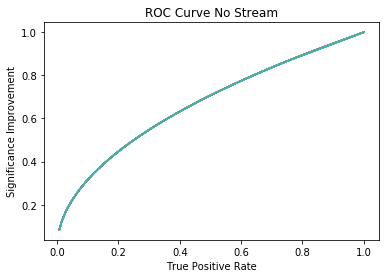

In [39]:
for x, y in zip(tpr_no_stream, tpr_no_stream):
    plt.plot(x, x/y**0.5)
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.title("ROC Curve No Stream")
plt.show()

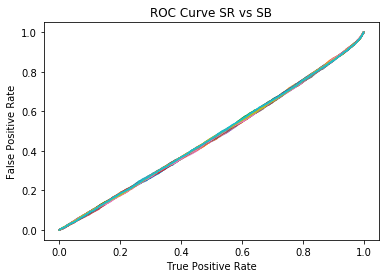

In [40]:
for x, y in zip(tpr_no_stream_stream_background, fpr_no_stream_stream_background):
    plt.plot(x, y)
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve SR vs SB")
plt.show()

## Signal and sideband without stream, signal shifted to right

In [41]:
SR = gaiadata2_no_stream[(gaiadata2_no_stream[:,0] > -4) * (gaiadata2_no_stream[:,0] < 0)]
SB = gaiadata2_no_stream[(gaiadata2_no_stream[:,0] > -8.25)*(gaiadata2_no_stream[:,0] < -4)+(gaiadata2_no_stream[:,0] > 0)*(gaiadata2_no_stream[:,0] < 4.5)]
stream = gaiadata3

SR, SB, stream = build_data_arrays(SR, SB, stream, 0)

Text(0, 0.5, 'counts')

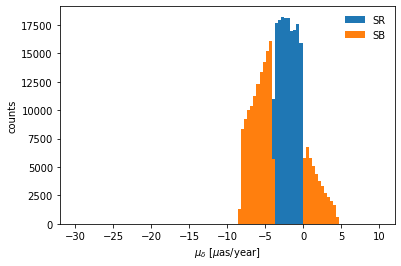

In [42]:
_,_,_=plt.hist(SR[:,0],bins=np.linspace(-30,10,100),label="SR")
_,_,_=plt.hist(SB[:,0],bins=np.linspace(-30,10,100),label="SB")
plt.legend(frameon=False)
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")
plt.ylabel("counts")

In [43]:
tpr_no_stream_sr_right, fpr_no_stream_sr_right, tpr_no_stream_sr_right_stream_background, fpr_no_stream_sr_right_stream_background = build_model(SR, SB, stream)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


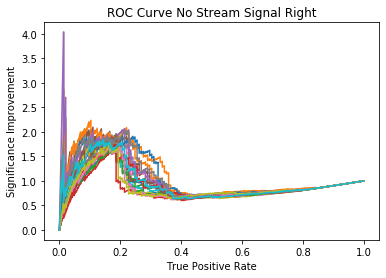

In [44]:
for x, y in zip(tpr_no_stream_sr_right, fpr_no_stream_sr_right):
    plt.plot(x, x/y**0.5)
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.title("ROC Curve No Stream Signal Right")
plt.show()

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


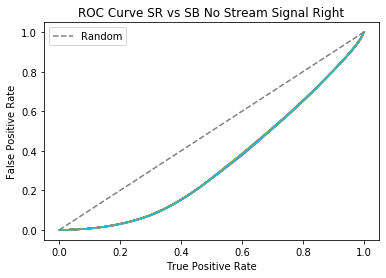

In [45]:
for x, y in zip(tpr_no_stream_sr_right_stream_background, fpr_no_stream_sr_right_stream_background):
    plt.plot(x, y)
plt.plot([0, 1], [0, 1], 'gray', ls = '--', label = 'Random')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve SR vs SB No Stream Signal Right")
plt.show()

## Fractions of Stream

In [46]:
fractions = [10, 100, 250, 500, 750]
gaiadata_stream_fractions = [[] for x in fractions]
tpr_fractions = [[] for x in fractions]
fpr_fractions = [[] for x in fractions]
tpr_fractions_stream_background = [[] for x in fractions]
fpr_fractions_stream_background = [[] for x in fractions]

import random
for counter in range(len(fractions)):
    print(counter)
    gaiadata_stream_fractions[counter] = gaiadata2_no_stream
    
    for i in range(len(gaiadata3)):
        if random.randint(0, 1000) < fractions[counter]:
            gaiadata_stream_fractions[counter] = np.append(gaiadata_stream_fractions[counter], [gaiadata3[i]], 0)
    
    
    SR, SB, stream = build_signal_sideband_stream(gaiadata_stream_fractions[counter], gaiadata3)

    SR, SB, stream = build_data_arrays(SR, SB, stream, 0)

    tpr_fractions[counter], fpr_fractions[counter], tpr_fractions_stream_background[counter], fpr_fractions_stream_background[counter] = build_model(SR, SB, stream)
    

0
1
2
3
4


In [47]:
sig_improvements = [[] for x in range(len(fractions)+1)]
for i in range(len(fractions)):
    sig_improvements[i] = [x/y**0.5 for x, y in zip(tpr_fractions[i], fpr_fractions[i])]
sig_improvements[len(fractions)] = [x/y**0.5 for x, y in zip(tpr_no_rot, fpr_no_rot)]

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Maximum significance improvement for \n20 Significance Improvement Curves vs. Fraction of Stream 100 included')

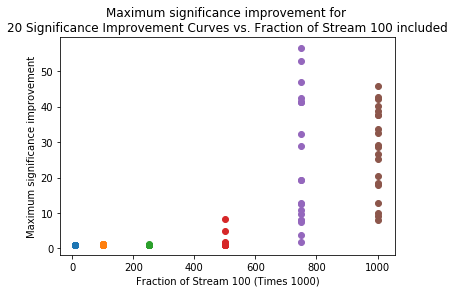

In [48]:
fractions.append(1000.)
for i in range(len(sig_improvements)):
    plt.scatter([fractions[i]]*20, [max(y[np.isfinite(y)]) for y in sig_improvements[i]])
plt.xlabel("Fraction of Stream " + str(stream_num) + " (Times 1000)")
plt.ylabel("Maximum significance improvement")
plt.title("Maximum significance improvement for \n20 Significance Improvement Curves vs. Fraction of Stream " + str(stream_num) + " included")

Text(0.5, 1.0, 'Box and whisker plots for maximum significance improvement for \n 20 Significance Improvement Curves vs. Fraction of 100 included')

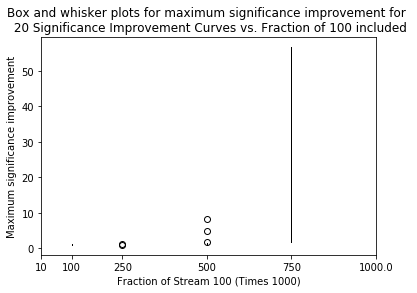

In [49]:
for i in range(len(sig_improvements)):
    plt.boxplot([max(y[np.isfinite(y)]) for y in sig_improvements[i]], positions = [fractions[i]])
plt.xlabel("Fraction of Stream " + str(stream_num) + " (Times 1000)")
plt.ylabel("Maximum significance improvement")
plt.title("Box and whisker plots for maximum significance improvement for \n 20 Significance Improvement Curves vs. Fraction of " + str(stream_num) + " included")

Text(0.5, 1.0, 'Mean of maximum significance improvement for \n 20 Significance Improvement Curves vs. Fraction of Stream 100 included')

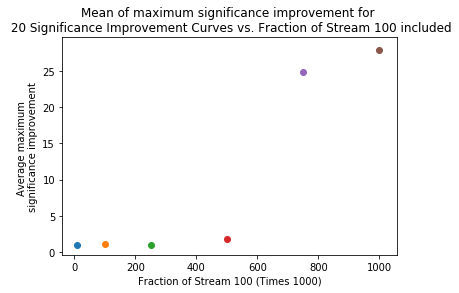

In [50]:
for i in range(len(sig_improvements)):
    plt.scatter([fractions[i]], np.mean([max(y[np.isfinite(y)]) for y in sig_improvements[i]]))
plt.xlabel("Fraction of Stream " + str(stream_num) + " (Times 1000)")
plt.ylabel("Average maximum \nsignificance improvement")
plt.title("Mean of maximum significance improvement for \n 20 Significance Improvement Curves vs. Fraction of Stream " + str(stream_num) + " included")

### Important variables

In [54]:
stream_num

100

In [57]:
original_sig

1.0282301407834695

In [61]:
num_stars = len(gaiadata2)
num_stars

449908

In [63]:
num_stream = len(gaiadata2[gaiadata2[:,6] != 0])
num_stream

145